In [3]:
from itertools import chain
import scipy
from scipy.optimize import fmin
from scipy.stats import norm
from scipy.stats import beta
from scipy.special import gamma as gammaf
import numpy as np
import random
import time
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

On découpe aléatoirement un génome en N fragments et on récupère la taille des fragments obtenus.
On cherche à vérifier que la distribution de la taille de ces fragments suit une loi bêta(1,N).

In [69]:
def get_parts(longueur, nbr_frag):
    """
    découpe aléatoirement un génome 
    <longueur>: longueur du génome à découper
    <nbr_frag>: nombre de fragments souhaités
    Return <nll>: liste de taille des fragments obtenus
    """
    cuts = set()
    while len(cuts) < nbr_frag - 1:
        cuts.add(random.randint(1, longueur - 1))
    cuts = [0] + list(sorted(cuts)) + [longueur]
    return [cuts[i + 1] - cuts[i] for i in range(len(cuts) - 1)]

On affiche l'histogramme de la distribution des tailles desfragments. 

Ici on a coupé un génome de taille 1 000 000 en N = 60 000 morceaux.

On affiche également la densité de la loi bêta de paramètres : 1,N

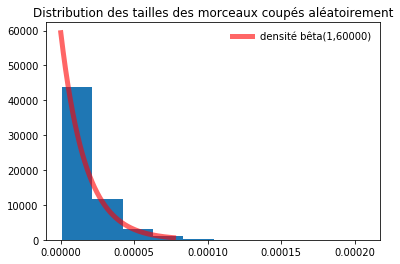

In [70]:
a=1
b=60000
taille = get_parts(1000000, 60000)
t = sum(taille)
taille = [i / t for i in taille]
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 60000)
plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='densité bêta(1,60000)')
plt.hist(taille)
plt.legend(loc='best', frameon=False)
plt.title("Distribution des tailles des morceaux coupés aléatoirement")
plt.show()

On remarque que la courbe de la densité de la loi bêta(1,60000) a la même allure que la distribution des tailles.

Nous allons ensuite "fitter" cette distribution en utilisant la méthode des moments et celle du maximum de vraisemblance afin d'estimer les paramètres de la loi bêta.



Soit la moyenne empirique : $m$ = $ \frac{1}{n} $$\sum_{i=1}^{n} x_{i}$ 

et la variance : $v$ = $ \frac{1}{n} $$\sum_{i=1}^{n} (x_{i}-m)$

D'après la méthode des moments on estime les paramètres de la loi bêta($\alpha$, $\beta$) 

$\alpha$ = $m$($ \frac{m(1-m)}{v}$$ - 1)$

$\beta$ = $(1-m)$($ \frac{m(1-m)}{v}$$-1)$


In [77]:
mean = np.mean(taille)
var = np.var(taille, ddof=1)

alpha1 = mean ** 2 * (1 - mean) / var - mean
beta1 = alpha1 * (1 - mean) / mean

print("Les paramètres estimés par la méthode des moments sont : alpha = ", alpha1, ", beta = ",beta1)


Les paramètres estimés par la méthode des moments sont : alpha =  1.0503279302630193 , beta =  63018.62548784105


In [85]:
def betaNLL(param, *args):
    """
    log négative vraisemblance pour bêta
    <param>: liste des paramètres à "fitter"
    <args>: données à "fitter"
    Return <nll>: log négative vraisemblance à minimiser
    """  
    a, b = param
    data = args[0]
    pdf = beta.pdf(data,a,b,loc=0,scale=1)
    lg = np.log(pdf)
    nll = -1*np.sum(lg)
    return nll

In [84]:
result = fmin(betaNLL, [1, 1], args=(taille,))
alpha2, beta2 = result
print("Les paramètres estimés par la méthode de la vraisemblance sont : \nalpha = ", alpha2, ", beta = ",beta2)



Optimization terminated successfully.
         Current function value: -600591.309665
         Iterations: 130
         Function evaluations: 260
Les paramètres estimés par la méthode de la vraisemblance sont : 
alpha =  1.1743532265928578 , beta =  70459.96364140954


/home/aghoul/venv/local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/aghoul/venv/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.3335626308581823
49.32420528189736


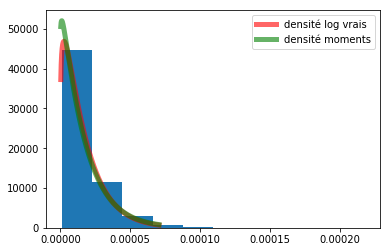

In [8]:

weights = np.ones_like(taille) / float(len(taille))

#plt.hist(taille, weights=weights)
fitted = lambda x, a, b: gammaf(a + b) / gammaf(a) / gammaf(b) * x ** (a - 1) * (1 - x) ** (b - 1)  # pdf of beta

xx = np.linspace(beta.ppf(0.01, alpha2, beta2), beta.ppf(0.99, alpha2, beta2), 60000)
plt.plot(xx, beta.pdf(xx, alpha2, beta2),'r-', lw=5, alpha=0.6, label='densité log vrais')
plt.plot(xx, beta.pdf(xx, alpha1, beta1),'g-', lw=5, alpha=0.6, label='densité moments')
plt.legend()
#plt.plot(xx, beta.pdf(xx, alpha3, beta3), lw=5, alpha=0.6, label='densité bêta(1,60000)')
#plt.plot(xx, fitted(xx, alpha1, beta1), 'g')
#plt.plot(xx, fitted(xx, alpha2, beta2), 'b')
#plt.plot(xx, fitted(xx, alpha3, beta3), 'r')


plt.hist(taille)

plt.show()

In [9]:
def frac(taille_échantillon, nombre_fragments):
    # On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
    échantillons_fracturés = []
    if nombre_fragments > taille_échantillon:
        raise ValueError(
            '\n\n\n'
            'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
            'Vous pouvez: \n'
            '\t- Réduire le nombre de fragments demandé, en jouant sur N \n'
            '\t- Augmenter la taille des échantillons à fracturer\n'
    )
    # Il y aura n - 1 fractures pour obtenir n elements
    nombre_fractures = nombre_fragments - 1

    # Une fracture sera placée avant l'index désigné, donc une fracture
    #   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
    fractures = set()
    while len(fractures) < nombre_fractures:
        fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
    if len(fractures) != nombre_fractures:
        if len(fractures) < nombre_fractures:
            raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
        fractures = set(list(fractures)[:nombre_fractures])
    fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
    échantillon_fracturé = [
        fractures[i + 1] - fractures[i] for i in range(len(fractures) - 1)
    ]
    if sum(échantillon_fracturé) != taille_échantillon:
        raise RuntimeError(
            "ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
            f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
            f" fragments de différence entre ce qu'on attendais et ce qu'on a"
            f" ({sum(échantillon_fracturé)} contre {taille_échantillon})"
        )
    échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
    échantillons_fracturés.append(échantillon_fracturé)

    return échantillons_fracturés


(0.9213799567784688, 8.38198147456498, 3.9999999999999996, 15493.535020960178)


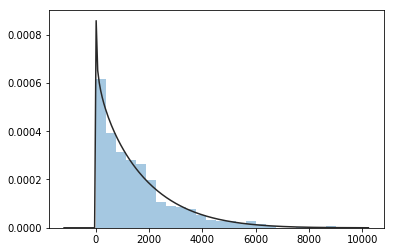

In [10]:
g = 1000000
n = 650
taille = frac(g,n)
sns.distplot(taille, kde=False, fit=beta)
print(beta.fit(taille))

In [11]:
lois = ['normale', 'uniforme', 'poisson']

def fracture(echantillons, n=65952, sigma=100, loi='normale'):
    """
    Fracture une liste d'échantillons en utilisant un nombre de fractures variables de loi n = Norm(N, sigma)
    :param sigma:
    :param n: Ecart-type
    :param echantillons:
    :return:
    """
    #
    échantillons_fracturés = []
    
    n = dict(
        normale = n + np.random.randn(len(echantillons)) * sigma,
        uniforme = np.random.uniform(0, 131206, len(echantillons)),
        poisson = np.random.poisson(65603, len(echantillons)), #erreur
        géométrique = np.random.geometric(1./65603, len(echantillons)),#erreur
        exponentielle = np.random.exponential(1./65603, len(echantillons)) 
    )[loi]

    for i in range(len(echantillons)):
        n[i]=n[i]/len(echantillons)
    
    # On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
    for index, (nombre_fragments, taille_échantillon) in enumerate(zip(map(int, n), echantillons)):

        if nombre_fragments > taille_échantillon:
            raise ValueError(
                '\n\n\n'
                'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
                'Vous pouvez: \n'
                '\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
                '\t- Augmenter la taille des échantillons à fracturer\n'
            )
        # Il y aura n - 1 fractures pour obtenir n elements
        nombre_fractures = nombre_fragments - 1

        # Une fracture sera placée avant l'index désigné, donc une fracture
        #   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
        fractures = set()
        while len(fractures) < nombre_fractures:
            fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
        if len(fractures) != nombre_fractures:
            if len(fractures) < nombre_fractures:
                raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
            fractures = set(list(fractures)[:nombre_fractures])
        fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
        échantillon_fracturé = [
            fractures[i + 1] - fractures[i] for i in range(len(fractures) - 1)
        ]
        if sum(échantillon_fracturé) != taille_échantillon:
            raise RuntimeError(
                "ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
                f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
                f" fragments de différence entre ce qu'on attendais et ce qu'on a"
                f" ({sum(échantillon_fracturé)} contre {taille_échantillon})"
            )
        échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
        échantillons_fracturés.append(échantillon_fracturé)

    return échantillons_fracturés


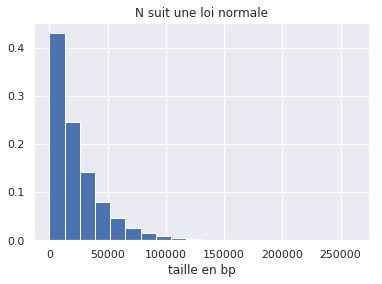

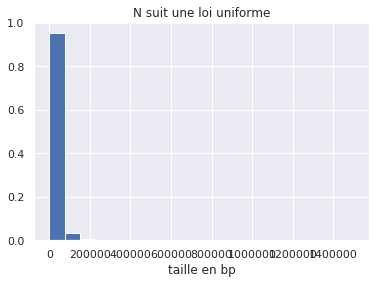

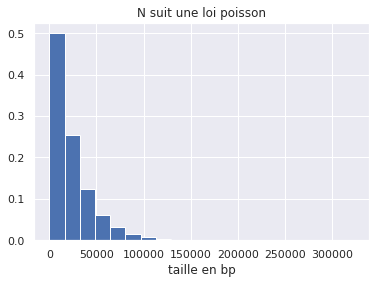

In [44]:
sns.set(color_codes=True)
# sns.distplot(fragments, kde=False, rug=False)
# plt.show()

taille_genome =1500000
nombre_morceaux = 65603
seuil = 80000

for loi in lois:
    fragments = list(chain.from_iterable(fracture([taille_genome] * 1000, nombre_morceaux, loi=loi)))
    #fragments = [x for x in fragments if x < seuil] 
    weights = np.ones_like(fragments) / float(len(fragments))
    plt.xlabel('taille en bp')
    plt.title('N suit une loi %s' %loi)
    plt.hist(fragments, bins=20, weights=weights)
    plt.show()

